In [82]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,TensorDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn.functional as F
import glob
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

In [13]:
transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Resize(64),
                              transforms.ToPILImage(),
                            transforms.CenterCrop(64),
                              transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [18]:
DATADir="../Scripts/Gans_img_cats/"
dataset = ImageFolder(root=DATADir,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [25]:
train_dl=DataLoader(dataset,batch_size=128,num_workers=0,shuffle=True,pin_memory=True)

In [26]:
for i,j in train_dl:
    print(i.shape)
    break


torch.Size([128, 3, 64, 64])


In [76]:
class MyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = glob.glob(os.path.join(path, "*.jpg"))
        self.transform = transform
#         self.label = label

    def __getitem__(self, index):
        img = cv2.imread(self.path)[index]
#         labels = torch.tensor(int(self.label))
        img=cv2.resize(img,(80,80))
        img=img/255.0
    
        if self.transform is not None:
            # Now you have PIL.Image instance for transforms
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.path)

In [85]:
dataset=MyDataset(DATADir,transform=transform)


In [78]:
train_dl=DataLoader(dataset,batch_size=64,num_workers=3,shuffle=True,pin_memory=True)

In [83]:
len(dataset)


15747

In [5]:
for i in os.listdir(DATADir[:200]):
    print(i)

1.jpg
10.jpg
100.jpg
1000.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
1001.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1002.jpg
10020.jpg
10021.jpg
10022.jpg
10023.jpg
10024.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
10029.jpg
1003.jpg
10030.jpg
10031.jpg
10032.jpg
10033.jpg
10034.jpg
10035.jpg
10036.jpg
10037.jpg
10038.jpg
10039.jpg
1004.jpg
10040.jpg
10041.jpg
10042.jpg
10043.jpg
10044.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
10049.jpg
1005.jpg
10050.jpg
10051.jpg
10052.jpg
10053.jpg
10054.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1006.jpg
10060.jpg
10061.jpg
10062.jpg
10063.jpg
10064.jpg
10065.jpg
10066.jpg
10067.jpg
10068.jpg
10069.jpg
1007.jpg
10070.jpg
10071.jpg
10072.jpg
10073.jpg
10074.jpg
10075.jpg
10076.jpg
10077.jpg
10078.jpg
10079.jpg
1008.jpg
10080.jpg
10081.jpg
10082.jpg
10083.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
10089.jp

In [5]:
X=[]
Y=[]
training_data=[]
for di in os.listdir(DATADir[:200]):
    if ".jpg" in di:
        DIR=os.path.join(DATADir,di)
        img_open=cv2.imread(DIR)
        gray = cv2.cvtColor(img_open, cv2.COLOR_BGR2RGB)
        img_resize=cv2.resize(gray,(80,80))
        X.append(img_resize)
        Y.append(0)

In [6]:
x=torch.Tensor([arr for arr in X])


In [7]:
y=torch.FloatTensor([arr for arr in Y])

In [8]:
x=x/255.0

In [10]:
train_data=TensorDataset(x,y)

In [11]:
train_dl=DataLoader(train_data,batch_size=64,shuffle=True,num_workers=3,pin_memory=True)

In [24]:
for i,j in train_dl:
    print(i.shape)
    break

torch.Size([100, 3, 64, 64])


In [38]:
path="C:/Users/PARIKALP/AppData/Local/Programs/Python/Scripts/Gans_imgs/cats"

In [16]:
generator=nn.Sequential(
    nn.ConvTranspose2d(784,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=1,padding=0,bias=False),
    nn.Tanh() )

In [21]:
class Discriminator(nn.Module):
    def __init__(self,img_dim):
        super().__init__()
        self.disc=nn.Sequential(nn.Linear(img_dim,128),
                               nn.LeakyReLU(0.1),
                               nn.Linear(128,1),
                               nn.Sigmoid())
        
    def forward(self,x):
        return self.disc(x)
    

In [18]:
class Generator(nn.Module):
    def __init__(self,z_dim,img_dim):
        super().__init__()
        self.gen=nn.Sequential(
            nn.Linear(z_dim,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,img_dim),
            nn.Tanh())
    
    def forward(self,x):
        return self.gen(x)

In [19]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
lr=3e-4
z_dim=64
image_dim=80
batch_size=32
num_epochs=50

In [46]:
disc=Discriminator(image_dim)
gen=Generator(z_dim,image_dim)

In [47]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# train_ds = ImageFolder(path, transform=transforms.Compose([transforms.Resize(image_size),
#                                                         transforms.CenterCrop(image_size),
#                                                         transforms.ToTensor(),
#                                                         transforms.Normalize(*stats)]))

In [50]:
opt_disc=torch.optim.Adam(disc.parameters(),lr=lr)
opt_gen=torch.optim.Adam(gen.parameters(),lr=lr)
fixed_noise=torch.randn((batch_size,z_dim))
criterion=nn.BCELoss()
writer_fake=SummaryWriter(f"../Scripts/Gans_imgs/fake")
writer_real=SummaryWriter(f"../Scripts/Gans_imgs/real")
step=0

In [51]:
for epoch in range(num_epochs):
    for batch_idx,(real,_) in enumerate(train_dl):
        real=real.view(-1,80)
        batch_size=real.shape[0]
        
        noise=torch.randn(batch_size,z_dim)
        fake=gen(noise)
        disc_real=disc(real).view(-1)
        lossD_real=criterion(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).view(-1)
        lossD_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
        lossD=(lossD_real + lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        output=disc(fake).view(-1)
        lossG=criterion(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] \ "
               f"Loss D: {lossD:.4f},Loss G:{lossG:.4f}")
            
            
            with torch.no_grad():
                fake=gen(fixed_noise).reshape(-1,1,80,80)
                data=real.reshape(-1,1,80,80)
                img_grid_fake=make_grid(fake,normalize=True)
                img_grid_real=make_grid(data,normalize=True)
                
                writer_fake.add_image("Fake Images",img_grid_fake,global_step=step)
                
                writer_real.add_image("Real Images",img_grid_real,global_step=step)
                
                step+=1
        
        
        
        
        
        
        
        
        

Epoch [0/50] \ Loss D: 0.6885,Loss G:0.6319
Epoch [1/50] \ Loss D: 0.6138,Loss G:0.8284
Epoch [2/50] \ Loss D: 0.5992,Loss G:1.0368
Epoch [3/50] \ Loss D: 0.6816,Loss G:0.7475
Epoch [4/50] \ Loss D: 0.6612,Loss G:0.6838
Epoch [5/50] \ Loss D: 0.6969,Loss G:0.6492
Epoch [6/50] \ Loss D: 0.6831,Loss G:0.7029
Epoch [7/50] \ Loss D: 0.6408,Loss G:0.7544
Epoch [8/50] \ Loss D: 0.6886,Loss G:0.6837
Epoch [9/50] \ Loss D: 0.7086,Loss G:0.6749
Epoch [10/50] \ Loss D: 0.6601,Loss G:0.7336
Epoch [11/50] \ Loss D: 0.6556,Loss G:0.6969
Epoch [12/50] \ Loss D: 0.6824,Loss G:0.7359
Epoch [13/50] \ Loss D: 0.6949,Loss G:0.6907
Epoch [14/50] \ Loss D: 0.6948,Loss G:0.7102
Epoch [15/50] \ Loss D: 0.7080,Loss G:0.6455
Epoch [16/50] \ Loss D: 0.6675,Loss G:0.7467
Epoch [17/50] \ Loss D: 0.6911,Loss G:0.7425
Epoch [18/50] \ Loss D: 0.6694,Loss G:0.8075
Epoch [19/50] \ Loss D: 0.6709,Loss G:0.7831
Epoch [20/50] \ Loss D: 0.7024,Loss G:0.7116
Epoch [21/50] \ Loss D: 0.6618,Loss G:0.7437
Epoch [22/50] \ Loss

In [123]:
image_size=64
batch_size=128

In [122]:

train_ds = ImageFolder(DATADir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)]))
# 

In [124]:

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [144]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [145]:

device = get_default_device()
device

device(type='cpu')

In [146]:

train_dl = DeviceDataLoader(train_dl, device)

In [125]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [126]:
latent_size=128

In [147]:

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [148]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [1]:

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

torch.Size([128, 3, 7, 7])


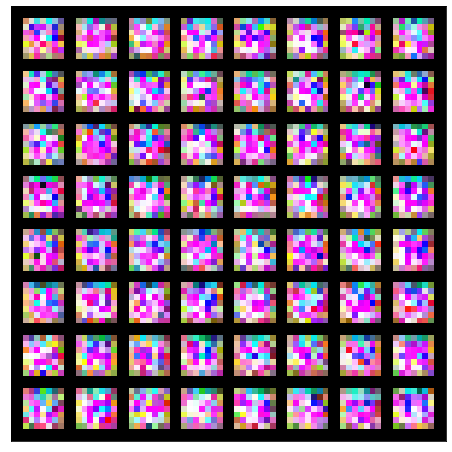

In [150]:
batch_size=128
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [151]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


In [152]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten()

torch.Size([128, 3, 64, 64])


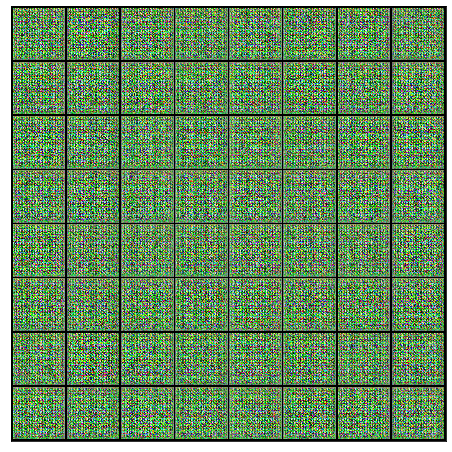

In [153]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [154]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [155]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [156]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [157]:
sample_dir = DATADir

In [158]:
def save_samples(index, latent_tensors, show=True):
    fake_images=generator(latent_tensors)
    fake_name='cats_img/{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_name),nrow=8)
    print('Saving', fake_name)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [159]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving cats_img/0000.png


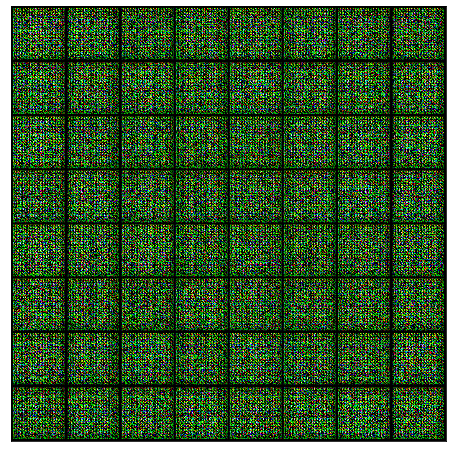

In [160]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
save_samples(0, fixed_latent)

In [161]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [162]:
lr = 0.0002
epochs = 60

In [ ]:

history = fit(epochs, lr)

100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [1:32:54<00:00, 44.95s/it]


Epoch [1/60], loss_g: 2.2706, loss_d: 0.7979, real_score: 0.6250, fake_score: 0.1849


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0001.png


100%|█████████████████████████████████████████████████████████████████████████████| 124/124 [4:34:28<00:00, 132.81s/it]


Epoch [2/60], loss_g: 3.0061, loss_d: 1.1535, real_score: 0.4201, fake_score: 0.0107


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0002.png


100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [2:47:08<00:00, 80.87s/it]


Epoch [3/60], loss_g: 4.9290, loss_d: 1.0559, real_score: 0.9148, fake_score: 0.5624


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0003.png


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [27:26<00:00, 13.28s/it]


Epoch [4/60], loss_g: 1.6078, loss_d: 1.1546, real_score: 0.4051, fake_score: 0.0430


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0004.png


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [27:53<00:00, 13.50s/it]


Epoch [5/60], loss_g: 3.7319, loss_d: 0.7027, real_score: 0.7264, fake_score: 0.2793


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0005.png


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [27:15<00:00, 13.19s/it]


Epoch [6/60], loss_g: 2.5144, loss_d: 1.2151, real_score: 0.4980, fake_score: 0.2388


  0%|                                                                                          | 0/124 [00:00<?, ?it/s]

Saving cats_img/0006.png


 71%|█████████████████████████████████████████████████████████▍                       | 88/124 [18:57<07:45, 12.92s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

